Las dos primeras lineas de código son para ejecutarlo en google colab subiendo las imágenes desde un zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/Practica2.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Practica2/train/labels/f14_frame3450.txt  
  inflating: Practica2/train/labels/f14_frame3600.txt  
  inflating: Practica2/train/labels/f14_frame3650.txt  
  inflating: Practica2/train/labels/f14_frame3800.txt  
  inflating: Practica2/train/labels/f14_frame3850.txt  
  inflating: Practica2/train/labels/f14_frame3950.txt  
  inflating: Practica2/train/labels/f14_frame400.txt  
  inflating: Practica2/train/labels/f14_frame4200.txt  
  inflating: Practica2/train/labels/f14_frame4350.txt  
  inflating: Practica2/train/labels/f14_frame4450.txt  
  inflating: Practica2/train/labels/f14_frame4500.txt  
  inflating: Practica2/train/labels/f14_frame4800.txt  
  inflating: Practica2/train/labels/f14_frame4850.txt  
  inflating: Practica2/train/labels/f14_frame4950.txt  
  inflating: Practica2/train/labels/f14_frame500.txt  
  inflating: Practica2/train/labels/f14_frame5100.txt  
  inflating: Practica2/train/labels/f14_frame

In [3]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import numpy as np
from numpy import vstack
from numpy import argmax
import matplotlib.pyplot as plt
import random

In [19]:
import math
def selection(url):
    label=open(url, 'r').read()
    array=label.split("\n")
    array.pop()
    dist=100
    for coord in array:
        coord=coord.split(" ")
        distaux=math.sqrt((0.5-float(coord[1]))**2+(0.5-float(coord[2]))**2)
        if distaux<dist:
            dist=distaux
            eleccion=coord
    return int(eleccion[0])

Como podemos observar en las dos siguientes celdas, usando la función selection obtendríamos ligera mejora en la uniformidad de la distribución de los valores, por lo que a priori mejoraría el modelo predictivo, primero porque al coger el valor más centrado se le haría más sencillo a la red neuronal predecirlo y segundo, porque se podría arreglar un poco el problema de underfitting que tiene este dataset ya que hay muchos de un tipo con respecto a otros tipos.

<BarContainer object of 7 artists>

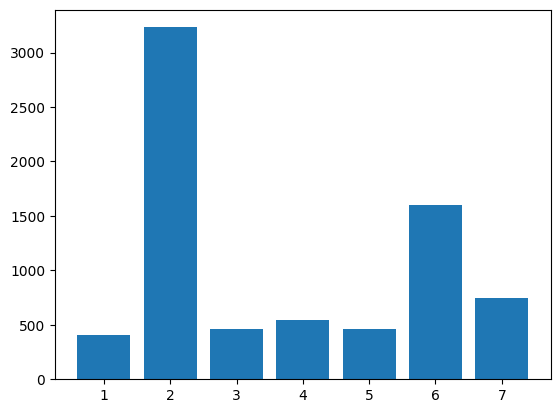

In [23]:
import glob
valores=[0, 0, 0, 0, 0, 0, 0]
for image_path in glob.glob("Practica2/train/labels/*.txt"):
    label=open(image_path, 'r').read()
    valor=int(label[0])
    valores[valor]+=1
x=[1,2,3,4,5,6,7]
plt.bar(x,valores)

<BarContainer object of 7 artists>

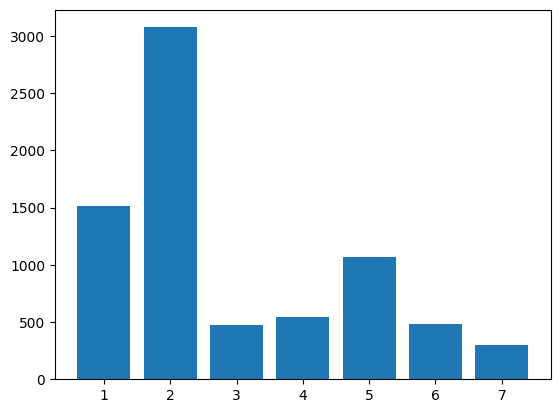

In [21]:

valores=[0, 0, 0, 0, 0, 0, 0]
for image_path in glob.glob("Practica2/train/labels/*.txt"):
    valor=selection(image_path)
    valores[valor]+=1
x=[1,2,3,4,5,6,7]
plt.bar(x,valores)

In [4]:
## Step 1: Create a dataloader for Pytorch
class VehiclesDataset(Dataset):
    def __init__(self, train_dir, img_list, transform = None):
        self.train_dir = train_dir
        self.transform = transform
        self.images = img_list
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.train_dir, self.images[index])
        label_path=image_path.replace('images','labels').replace(".jpg",".txt")
        label=int(selection(label_path))
        #label=int(open(label_path,'r').read()[0])

        img = np.array(Image.open(image_path))
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label)
        
        



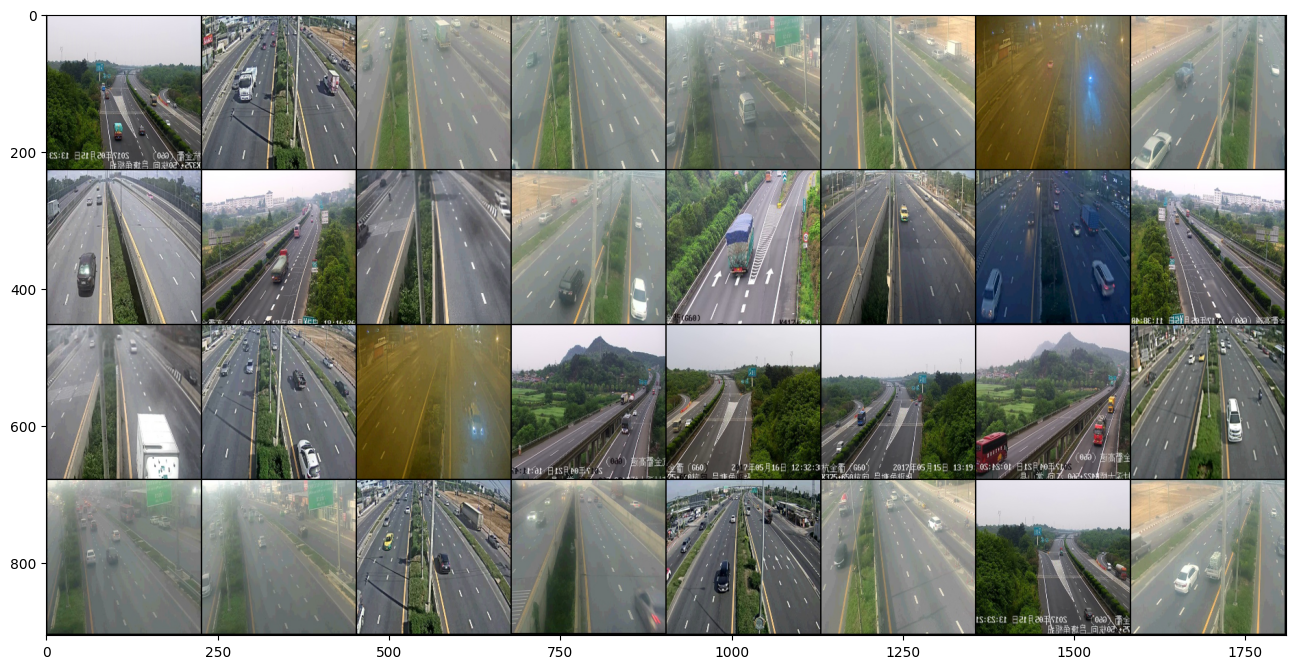

In [5]:
## Step 2: Create training dataset
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256),antialias=None),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip()
])

# Create dataloaders
train_dir = 'Practica2/train/images/'
train_img_list = os.listdir(train_dir)
val_dir='Practica2/valid/images/'
val_img_list =  os.listdir(val_dir)
train_dataset = VehiclesDataset(train_dir, train_img_list, transform = data_transform)
val_dataset = VehiclesDataset(val_dir, val_img_list, transform = data_transform)
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle=False)

# Visualize images in the dataset
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,32))
grid_imgs = torchvision.utils.make_grid(samples[:32])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()

Como podemos observar en la siguiente celda, las imágenes han pasado de una escala de 0 a 255 a una escala de 0 a 1.

In [17]:
train_dataset.__getitem__(0)[0]

tensor([[[0.7447, 0.7420, 0.7400,  ..., 0.5885, 0.8580, 0.9027],
         [0.7375, 0.7476, 0.7487,  ..., 0.5455, 0.7823, 0.6702],
         [0.7467, 0.7398, 0.7336,  ..., 0.5872, 0.8488, 0.4741],
         ...,
         [0.3782, 0.4146, 0.4054,  ..., 0.2944, 0.3032, 0.2978],
         [0.3976, 0.4175, 0.4063,  ..., 0.2816, 0.2745, 0.2856],
         [0.4199, 0.4255, 0.4040,  ..., 0.2503, 0.2637, 0.2821]],

        [[0.7729, 0.7751, 0.7710,  ..., 0.4768, 0.7473, 0.8250],
         [0.7650, 0.7805, 0.7839,  ..., 0.4295, 0.6658, 0.5832],
         [0.7743, 0.7674, 0.7689,  ..., 0.4711, 0.7233, 0.3855],
         ...,
         [0.3782, 0.4146, 0.4054,  ..., 0.3169, 0.3228, 0.3205],
         [0.3976, 0.4175, 0.4063,  ..., 0.2990, 0.2910, 0.3050],
         [0.4199, 0.4255, 0.4040,  ..., 0.2660, 0.2794, 0.2983]],

        [[0.8104, 0.8115, 0.8138,  ..., 0.4896, 0.7520, 0.8268],
         [0.7965, 0.8146, 0.8194,  ..., 0.4398, 0.6658, 0.5902],
         [0.7975, 0.7905, 0.7882,  ..., 0.4812, 0.7271, 0.

In [24]:
## Step 3: Define Deep Learning model
class scratch_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=100, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(100, 200, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(200, 400, 3, stride=1, padding=0)
        self.mpool = nn.MaxPool2d(kernel_size=3)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(19600,1024)
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,7)
        self.classifier = nn.Softmax(dim=1)
        
    def forward(self,x):
        x = self.mpool( self.relu(self.conv1(x)) )
        x = self.mpool( self.relu(self.conv2(x)) )
        x = self.mpool( self.relu(self.conv3(x)) )
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.classifier(x)
        return x

In [25]:
## Step 4: Define train_step and predict functions
def train_step(train_loader, model, optimizer, criterion, device):
    # define the optimization
    avg_loss = []
    predictions, actuals = list(), list()
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs)
        # calculate loss
        loss = criterion(yhat, targets)
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
        avg_loss.append(loss.item())
        # Get accruacy
        actual = targets.cpu().numpy()
        yhat = argmax(yhat.detach().cpu().numpy(), axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return sum(avg_loss)/len(avg_loss), acc

# evaluate the model
def evaluation_step(val_loader, model, criterion, device):
    avg_loss = []
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # evaluate the model on the test set
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        avg_loss.append(loss.item())
        # retrieve numpy array
        yhat = yhat.detach().cpu().numpy()
        actual = targets.cpu().numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return sum(avg_loss)/len(avg_loss), acc


In [26]:
## Step 5: Define main train function
def train(model, train_dataloader, val_dataloader, optimizer, criterion, device):
    num_epoch = 50
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
    for epoch in range(1, num_epoch + 1):
        train_loss, train_acc = train_step(train_dataloader, model, optimizer, criterion, device)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc*100)
        print(f"Train: Loss at epoch {epoch} is {train_loss} and accuracy is {train_acc*100}%")
        val_loss, val_acc = evaluation_step(val_dataloader, model, criterion, device)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc*100)
        print(f"Validation: Loss at epoch {epoch} is {val_loss} and accuracy is {val_acc*100}%")
        torch.save(model.state_dict(), model_file_name)
    return model, train_loss_list, train_acc_list, val_loss_list, val_acc_list


In [ ]:
# Step 6: Training parameters, model declaration and training/validation process
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
model = scratch_nn()
model = model.to(device)

lr = 0.001
weight_dec = 0.001
model_file_name = "vehicles_model.pth"
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_dec)
criterion = nn.CrossEntropyLoss()
model, train_loss, train_acc, val_loss, val_acc = train(model, train_dataloader, val_dataloader, optimizer, criterion, device)

Como podemos ver en el siguiente gráfico a partir de un punto no hay mejora y esto se debe al underfitting del modelo por las imágenes escogidas.

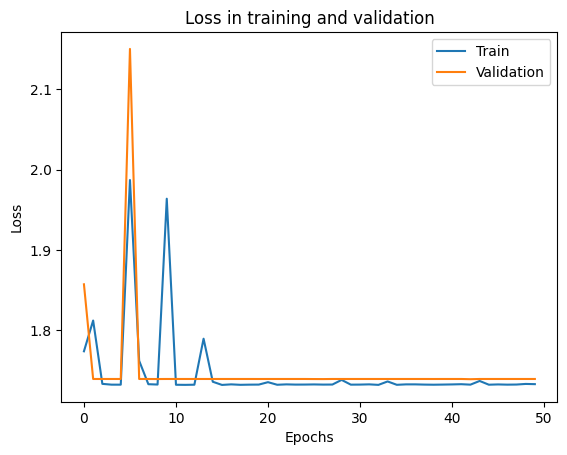

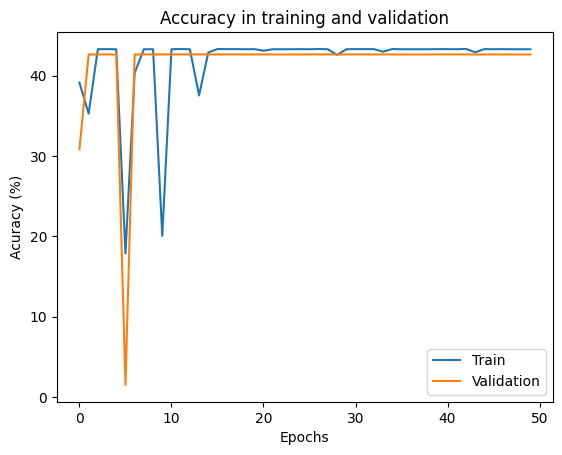

In [ ]:
# Step 7: Show results
plt.figure(1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Loss in training and validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.figure(2)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title("Accuracy in training and validation")
plt.xlabel("Epochs")
plt.ylabel("Acuracy (%)")
plt.legend(["Train", "Validation"])

plt.show()

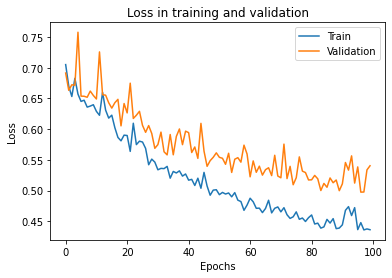

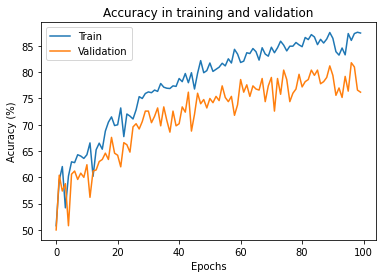

In [ ]:
# Step 7: Show results
plt.figure(1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Loss in training and validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

plt.figure(2)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title("Accuracy in training and validation")
plt.xlabel("Epochs")
plt.ylabel("Acuracy (%)")
plt.legend(["Train", "Validation"])

plt.show()